- 모델 (은닉층 2개만)

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Flatten, Dense, Input, concatenate, Dropout
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.utils import to_categorical #원 핫 인코딩

from tensorflow.keras.applications import Xception, ResNet50, InceptionV3, MobileNet
from tensorflow.keras.callbacks import EarlyStopping

import shutil
import os
import cv2
import glob

from datetime import datetime

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
dataset_path = '/content/gdrive/MyDrive/Colab Notebooks/data'
shutil.copy(os.path.join(dataset_path, '0118food.zip'), '/content')

'/content/0118food.zip'

- food
  - train
    - burger
    - chicken
    - pasta
    - pizza
    - porkcutlet
    - sushi
    - tteokbokki
  - test
    - ..

In [4]:
# 꼭대기 폴더 'food' 안에 각 폴더+정답이름이미지폴더 만들어서 진행할 것

DATA_ROOT_DIR = os.path.join('/content', 'food') #꼭대기 폴더 지정
TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'train')
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'test')

In [5]:
### food.zip 압축풀기
import zipfile
with zipfile.ZipFile(os.path.join('/content', '0118food.zip'), 'r') as target_file:
    target_file.extractall(TRAIN_DATA_ROOT_DIR)

In [6]:
# test폴더 - Pasta,Burger, ... 폴더 생성
os.mkdir(TEST_DATA_ROOT_DIR)
os.mkdir(os.path.join(TEST_DATA_ROOT_DIR, 'pasta'))
os.mkdir(os.path.join(TEST_DATA_ROOT_DIR, 'burger'))
os.mkdir(os.path.join(TEST_DATA_ROOT_DIR, 'chicken'))
os.mkdir(os.path.join(TEST_DATA_ROOT_DIR, 'sushi'))
os.mkdir(os.path.join(TEST_DATA_ROOT_DIR, 'pizza'))
os.mkdir(os.path.join(TEST_DATA_ROOT_DIR, 'porkcutlet'))
os.mkdir(os.path.join(TEST_DATA_ROOT_DIR, 'tteokbokki'))

In [7]:
import glob
ratio = 0.2

src_root_dir = "/content/food/train/"
dst_root_dir = "/content/food/test/"

label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
for label_name in label_name_list:
    train_image_file_list = glob.glob(src_root_dir + label_name + "/*.*")
    print("==========================================================")
    
    print("total [%s] image file nums => [%s]"%(label_name, len(train_image_file_list)))
    
    split_num = int(ratio * len(train_image_file_list))
    print("분리할 갯수 : ", split_num)
    
    test_image_file_list = train_image_file_list[0:split_num]
    
    # move
    move_nums = 0
    for image_file in test_image_file_list:
        shutil.move(image_file, dst_root_dir + label_name)
        move_nums = move_nums + 1
        
    print("total move nums => ", move_nums)
    print("===========================================================")

total [sushi] image file nums => [3650]
분리할 갯수 :  730
total move nums =>  730
total [pasta] image file nums => [3562]
분리할 갯수 :  712
total move nums =>  712
total [chicken] image file nums => [3580]
분리할 갯수 :  716
total move nums =>  716
total [burger] image file nums => [4024]
분리할 갯수 :  804
total move nums =>  804
total [porkcutlet] image file nums => [4756]
분리할 갯수 :  951
total move nums =>  951
total [tteokbokki] image file nums => [3695]
분리할 갯수 :  739
total move nums =>  739
total [pizza] image file nums => [4814]
분리할 갯수 :  962
total move nums =>  962


In [8]:
label_name_list

['sushi', 'pasta', 'chicken', 'burger', 'porkcutlet', 'tteokbokki', 'pizza']

## 훈련용 데이터

In [9]:
import cv2

train_data_list = []
train_label_list = [] #정답

class_dict = {'burger':0, 'chicken':1, 'pasta':2, 'pizza':3, 'porkcutlet':4, 'sushi':5, 'tteokbokki':6}

start_time = datetime.now()
for label_name in label_name_list:
  file_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
  img_file_list = glob.glob(file_path + '/*.*') #여기서 읽어온 것 아니고 읽어올 리스트만 가져온 것

  for img in img_file_list:
    src_img = cv2.imread(img, cv2.IMREAD_COLOR)
    src_img = cv2.resize(src_img, dsize=(128, 128)) #사진크기
    src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

    train_data_list.append(src_img)
    train_label_list.append(class_dict[label_name]) #정답(문자-> 0, 1로 바꿔주기; dict[key값]으로 0, 1 가져오기. 간단하게 이렇게 할수도)
end_time = datetime.now()
print('Elapsed Time : ', end_time-start_time)

Elapsed Time :  0:00:42.445703


In [10]:
X_train = np.array(train_data_list).astype('float32')
y_train = np.array(train_label_list).astype('float32')

print(X_train.shape, y_train.shape)

(22467, 128, 128, 3) (22467,)


## 테스트용 데이터

In [11]:
test_data_list = []
test_label_list = [] #정답

for label_name in label_name_list:
  file_path = os.path.join(TEST_DATA_ROOT_DIR, label_name)
  img_file_list = glob.glob(file_path + '/*.*') #여기서 읽어온 것 아니고 읽어올 리스트만 가져온 것

  for img in img_file_list:
    src_img = cv2.imread(img, cv2.IMREAD_COLOR)
    src_img = cv2.resize(src_img, dsize=(128, 128)) 
    src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

    test_data_list.append(src_img)
    test_label_list.append(class_dict[label_name])

In [12]:
X_test = np.array(test_data_list).astype('float32')
y_test = np.array(test_label_list).astype('float32')

print(X_test.shape, y_test.shape)

(5614, 128, 128, 3) (5614,)


In [13]:
len(os.listdir(TRAIN_DATA_ROOT_DIR))

7

In [14]:
# 정규화
X_train = X_train / 255.0
X_test = X_test / 255.0

## 전이학습

In [15]:
# 모바일넷
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
base_model.summary()

17225924/17225924 [==============================] - 1s 0us/step
Model: "mobilenet_1.00_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 32) 

In [16]:
class_nums = len(os.listdir(TRAIN_DATA_ROOT_DIR)) #정답 개수
print(class_nums)

7


In [17]:
model = Sequential()

model.add(base_model)
model.add(GlobalAveragePooling2D())


model.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.25))

model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.25))



model.add(Dense(class_nums, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                65600     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

In [18]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])

In [19]:
from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


# earlystopping = EarlyStopping(monitor='val_loss',  # 모니터 기준 설정 (val loss) 
#                               patience=5,          # 5회 Epoch동안 개선되지 않는다면 종료
#                              )


start_time = datetime.now()

hist = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=128) #callbacks=[earlystopping]

end_time = datetime.now()
print('elapsed time = ', end_time-start_time)

Epoch 1/50
176/176 [==============================] - 55s 248ms/step - loss: 2.4464 - accuracy: 0.2600 - val_loss: 1.4041 - val_accuracy: 0.4733
Epoch 2/50
176/176 [==============================] - 42s 238ms/step - loss: 1.5025 - accuracy: 0.4403 - val_loss: 0.9374 - val_accuracy: 0.7038
Epoch 3/50
176/176 [==============================] - 42s 236ms/step - loss: 1.1085 - accuracy: 0.5922 - val_loss: 0.6527 - val_accuracy: 0.8197
Epoch 4/50
176/176 [==============================] - 42s 236ms/step - loss: 0.8498 - accuracy: 0.7033 - val_loss: 0.4994 - val_accuracy: 0.8550
Epoch 5/50
176/176 [==============================] - 42s 237ms/step - loss: 0.7007 - accuracy: 0.7642 - val_loss: 0.4177 - val_accuracy: 0.8728
Epoch 6/50
176/176 [==============================] - 42s 238ms/step - loss: 0.6067 - accuracy: 0.7974 - val_loss: 0.3682 - val_accuracy: 0.8846
Epoch 7/50
176/176 [==============================] - 41s 235ms/step - loss: 0.5290 - accuracy: 0.8270 - val_loss: 0.3344 - val_ac

In [ ]:
# 0.9881 / 0.9478 :  (food.zip/yespizz.h5) epochs=50, batch_size=128, learning_rate=0.00001
# 0.9927  0.9526 :  (0118food.zip) 은닉층 2개(64, 128) epochs=50, batch_size=128, learning_rate=0.00001

In [20]:
model.save('finalfood_hidden2.h5')

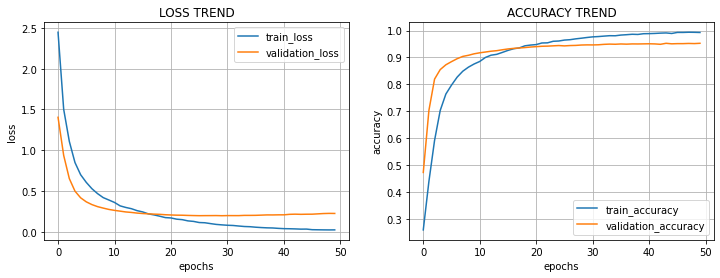

In [21]:
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.title("LOSS TREND")
plt.xlabel("epochs")
plt.ylabel('loss')
plt.grid()

plt.plot(hist.history['loss'], label='train_loss')
plt.plot(hist.history['val_loss'], label='validation_loss')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title("ACCURACY TREND")
plt.xlabel("epochs")
plt.ylabel('accuracy')
plt.grid()

plt.plot(hist.history['accuracy'], label='train_accuracy')
plt.plot(hist.history['val_accuracy'], label='validation_accuracy')
plt.legend(loc='best')

## predict1


In [22]:
# 이미지 불러오기, 색상변환, 크기조정, 정규화
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
pred_img_list = []
pred_img_name_list = glob.glob('./predict/*.*')
for i in range(len(pred_img_name_list)):
    src_img = cv2.imread(pred_img_name_list[i], cv2.IMREAD_COLOR)
    src_img = cv2.resize(src_img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH))
    src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
    src_img = src_img / 255.0
    pred_img_list.append(src_img)
len(pred_img_list)

36

In [23]:
pred_img_array = np.array(pred_img_list) #3차원 한번더 묶어서 4차원으로 차원 맞추기
pred_img_array.shape

(36, 128, 128, 3)

In [24]:
pred = model.predict(pred_img_array)

2/2 [==============================] - 1s 182ms/step


In [25]:
# {'burger':0, 'chicken':1, 'pasta':2, 'pizza':3, 'porkcutlet':4, 'sushi':5, 'tteokbokki':6}

class_name = ['burger', 'chicken', 'pasta', 'pizza', 'porkcutlet', 'sushi', 'tteokbokki']
for i in range(len(pred)):
    class_index = np.argmax(pred[i])
    print(str(i+1) + '번째 : ' + class_name[class_index], pred[i].max())

1번째 : pizza 0.99999774
2번째 : tteokbokki 0.9999987
3번째 : porkcutlet 0.99996257
4번째 : pizza 0.99992836
5번째 : pasta 0.99999857
6번째 : tteokbokki 1.0
7번째 : pizza 0.99549687
8번째 : sushi 1.0
9번째 : tteokbokki 0.9345794
10번째 : pasta 0.9999999
11번째 : sushi 0.99999964
12번째 : tteokbokki 0.9999999
13번째 : chicken 0.999874
14번째 : pasta 0.9999871
15번째 : sushi 0.99949956
16번째 : pizza 0.9997292
17번째 : pizza 0.9999932
18번째 : porkcutlet 0.99967146
19번째 : pasta 0.99999964
20번째 : pasta 0.9994691
21번째 : pasta 1.0
22번째 : tteokbokki 1.0
23번째 : pizza 0.9547805
24번째 : pasta 0.9999993
25번째 : pizza 0.92842174
26번째 : porkcutlet 0.9973139
27번째 : pasta 0.8573204
28번째 : tteokbokki 0.99998474
29번째 : sushi 1.0
30번째 : chicken 0.999998
31번째 : pizza 0.9966882
32번째 : pasta 0.9999981
33번째 : burger 0.5884311
34번째 : sushi 0.9999999
35번째 : burger 0.7181613
36번째 : pasta 0.7248162


In [26]:
# 상위 3개 예측값
top3 = 3
for i in range(len(pred)):
    sorted_index = pred[i].argsort()
    sorted_index = sorted_index[::-1]
    print("===================================")
    print(str(i+1) + '번째')
    print(sorted_index)
    for j in range(top3):
        pred_val = pred[i, sorted_index[j]]
        class_index = sorted_index[j]
        print("예측값 : ", class_name[class_index], pred_val)

1번째
[3 2 6 4 0 5 1]
예측값 :  pizza 0.99999774
예측값 :  pasta 8.295222e-07
예측값 :  tteokbokki 6.620841e-07
2번째
[6 2 1 0 4 3 5]
예측값 :  tteokbokki 0.9999987
예측값 :  pasta 1.0506533e-06
예측값 :  chicken 1.3242516e-07
3번째
[4 6 0 3 5 1 2]
예측값 :  porkcutlet 0.99996257
예측값 :  tteokbokki 1.5714815e-05
예측값 :  burger 1.3444157e-05
4번째
[3 1 2 0 6 4 5]
예측값 :  pizza 0.99992836
예측값 :  chicken 5.5623084e-05
예측값 :  pasta 1.4224393e-05
5번째
[2 6 3 0 5 4 1]
예측값 :  pasta 0.99999857
예측값 :  tteokbokki 9.206568e-07
예측값 :  pizza 3.3883381e-07
6번째
[6 2 4 1 3 0 5]
예측값 :  tteokbokki 1.0
예측값 :  pasta 3.1246195e-08
예측값 :  porkcutlet 7.718384e-09
7번째
[3 2 0 6 4 1 5]
예측값 :  pizza 0.99549687
예측값 :  pasta 0.004167356
예측값 :  burger 0.00012208708
8번째
[5 0 2 4 6 1 3]
예측값 :  sushi 1.0
예측값 :  burger 7.872229e-11
예측값 :  pasta 4.3361287e-11
9번째
[6 2 1 3 0 5 4]
예측값 :  tteokbokki 0.9345794
예측값 :  pasta 0.04854603
예측값 :  chicken 0.010740777
10번째
[2 6 4 3 5 1 0]
예측값 :  pasta 0.9999999
예측값 :  tteokbokki 4.4139227e-08
예측값 :  porkcutlet 2.5

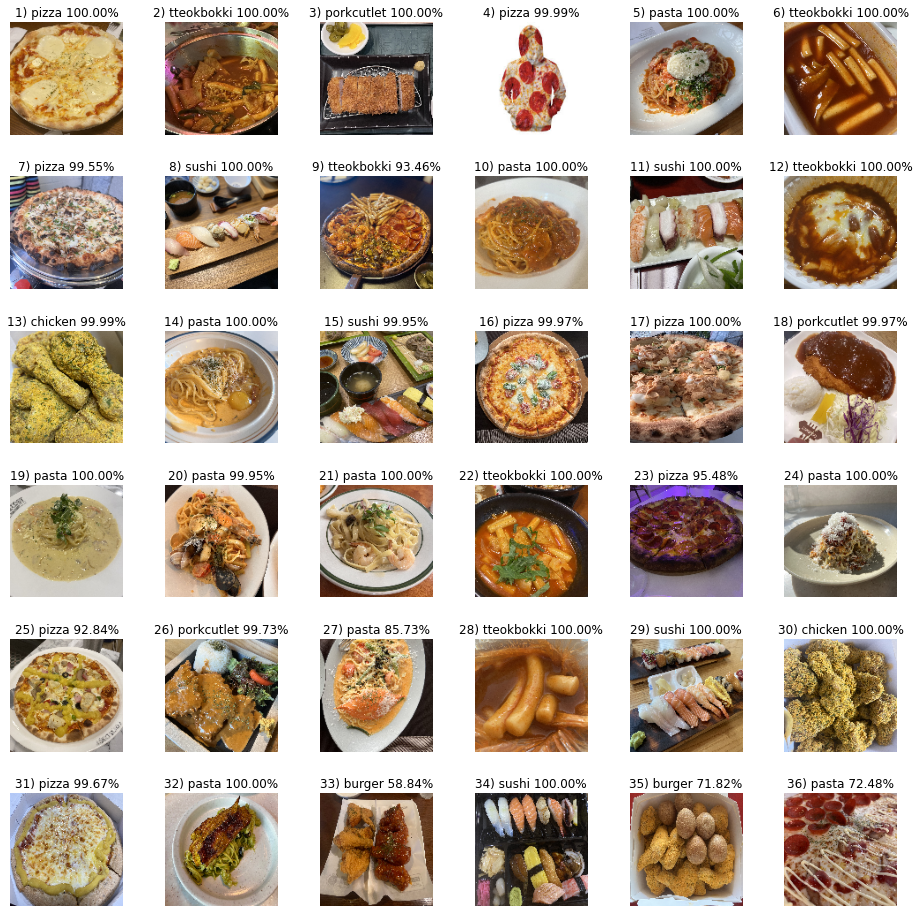

In [28]:
plt.figure(figsize=(13,13))

for i in range(len(pred)):
    plt.subplot(round(len(pred)/6), 6, i+1)
    class_index = np.argmax(pred[i])
    strTitle = str('{0:0.2f}'.format(100*max(pred[i]))) + '%'
    plt.title(str(i+1) + ') ' + class_name[class_index] + ' ' + strTitle) 
    plt.imshow(pred_img_list[i])
    plt.axis('off')
plt.tight_layout()

In [3]:
model = load_model('finalfood_hidden2.h5')

## predict2

In [7]:
# 이미지 불러오기, 색상변환, 크기조정, 정규화
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
pred_img_list = []
pred_img_name_list = glob.glob('./predict2/*.*')
for i in range(len(pred_img_name_list)):
    src_img = cv2.imread(pred_img_name_list[i], cv2.IMREAD_COLOR)
    src_img = cv2.resize(src_img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH))
    src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
    src_img = src_img / 255.0
    pred_img_list.append(src_img)
len(pred_img_list)

36

In [8]:
pred_img_array = np.array(pred_img_list) #3차원 한번더 묶어서 4차원으로 차원 맞추기
pred_img_array.shape

(36, 128, 128, 3)

In [9]:
pred = model.predict(pred_img_array)

2/2 [==============================] - 1s 57ms/step


In [10]:
# {'burger':0, 'chicken':1, 'pasta':2, 'pizza':3, 'porkcutlet':4, 'sushi':5, 'tteokbokki':6}

class_name = ['burger', 'chicken', 'pasta', 'pizza', 'porkcutlet', 'sushi', 'tteokbokki']
for i in range(len(pred)):
    class_index = np.argmax(pred[i])
    print(str(i+1) + '번째 : ' + class_name[class_index], pred[i].max())

1번째 : porkcutlet 0.9999704
2번째 : pasta 0.9999996
3번째 : pasta 0.99999994
4번째 : sushi 0.99999994
5번째 : pizza 0.954781
6번째 : tteokbokki 0.9999998
7번째 : pizza 0.99999315
8번째 : pasta 0.99998707
9번째 : porkcutlet 0.997314
10번째 : porkcutlet 0.9999625
11번째 : pasta 0.8573211
12번째 : tteokbokki 0.93457943
13번째 : sushi 0.9999998
14번째 : pizza 0.9954967
15번째 : burger 0.7181599
16번째 : pizza 0.99999756
17번째 : burger 0.58842796
18번째 : chicken 0.9998739
19번째 : porkcutlet 0.99967146
20번째 : chicken 0.9999978
21번째 : sushi 0.9999997
22번째 : pizza 0.9997294
23번째 : tteokbokki 0.99999994
24번째 : tteokbokki 0.9999986
25번째 : tteokbokki 0.99999994
26번째 : pasta 0.99946916
27번째 : pizza 0.99668795
28번째 : sushi 0.99999994
29번째 : pasta 0.9999985
30번째 : pasta 0.72481644
31번째 : pasta 0.9995946
32번째 : pizza 0.9284227
33번째 : pasta 0.9999981
34번째 : pasta 1.0
35번째 : pasta 0.9999993
36번째 : sushi 0.99949956


In [11]:
# 상위 3개 예측값
top3 = 3
for i in range(len(pred)):
    sorted_index = pred[i].argsort()
    sorted_index = sorted_index[::-1]
    print("===================================")
    print(str(i+1) + '번째')
    print(sorted_index)
    for j in range(top3):
        pred_val = pred[i, sorted_index[j]]
        class_index = sorted_index[j]
        print("예측값 : ", class_name[class_index], pred_val)

1번째
[4 5 3 0 6 2 1]
예측값 :  porkcutlet 0.9999704
예측값 :  sushi 2.1542508e-05
예측값 :  pizza 2.8806407e-06
2번째
[2 3 4 5 6 0 1]
예측값 :  pasta 0.9999996
예측값 :  pizza 1.5027977e-07
예측값 :  porkcutlet 1.2345994e-07
3번째
[2 6 4 3 5 1 0]
예측값 :  pasta 0.99999994
예측값 :  tteokbokki 4.4139394e-08
예측값 :  porkcutlet 2.5904102e-08
4번째
[5 6 0 4 2 1 3]
예측값 :  sushi 0.99999994
예측값 :  tteokbokki 7.815624e-09
예측값 :  burger 7.499515e-09
5번째
[3 2 6 0 1 4 5]
예측값 :  pizza 0.954781
예측값 :  pasta 0.044510547
예측값 :  tteokbokki 0.0006006294
6번째
[6 2 0 4 1 3 5]
예측값 :  tteokbokki 0.9999998
예측값 :  pasta 1.0729621e-07
예측값 :  burger 2.61111e-08
7번째
[3 2 0 4 5 6 1]
예측값 :  pizza 0.99999315
예측값 :  pasta 5.3985286e-06
예측값 :  burger 7.1727175e-07
8번째
[2 6 1 5 4 3 0]
예측값 :  pasta 0.99998707
예측값 :  tteokbokki 1.2433146e-05
예측값 :  chicken 1.973616e-07
9번째
[4 5 0 6 3 1 2]
예측값 :  porkcutlet 0.997314
예측값 :  sushi 0.0011573673
예측값 :  burger 0.0011084722
10번째
[4 6 0 3 5 1 2]
예측값 :  porkcutlet 0.9999625
예측값 :  tteokbokki 1.5715039e-05
예측값

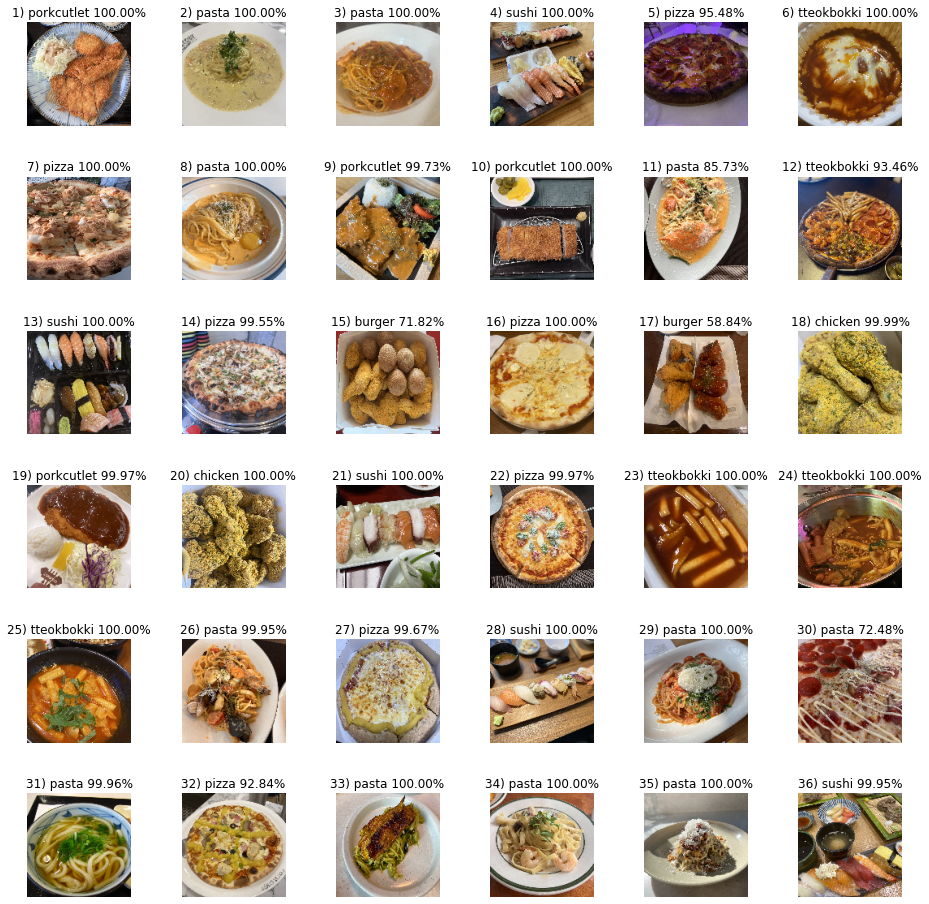

In [12]:
plt.figure(figsize=(13,13))

for i in range(len(pred)):
    plt.subplot(round(len(pred)/6), 6, i+1)
    class_index = np.argmax(pred[i])
    strTitle = str('{0:0.2f}'.format(100*max(pred[i]))) + '%'
    plt.title(str(i+1) + ') ' + class_name[class_index] + ' ' + strTitle) 
    plt.imshow(pred_img_list[i])
    plt.axis('off')
plt.tight_layout()

## 오답리스트

In [ ]:
##### 오답 리스트

ret_val = model.predict(X_test.reshape(-1,32,32,3))
print('type(ret_val) = ', type(ret_val), ', ret_val.shape = ', ret_val.shape)


predicted_val = np.argmax(ret_val, axis=1)  
prediction_label_comp_val = np.equal(predicted_val, y_test)


index_label_prediction_list = [ [index, y_test[index], predicted_val[index] ]  
    for index, result in enumerate(prediction_label_comp_val)  if result == False ]

print(len(index_label_prediction_list))

print(index_label_prediction_list)

false_data_index = np.random.randint(len(index_label_prediction_list))

mnist_index = index_label_prediction_list[false_data_index][0]
label = index_label_prediction_list[false_data_index][1]
prediction = index_label_prediction_list[false_data_index][2]

title_str = 'index = ' + str(mnist_index) + ' , label = ' + str(label) + \
' , prediction = ' + str(prediction)

img = X_test[mnist_index]

plt.title(title_str)
plt.imshow(img, cmap='gray')
plt.show()